In [256]:
import pandas
import seaborn
import sklearn
import functions as covid_lib
from numpy import hstack, array
from random import random
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as plt

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objects as go
from dash.dependencies import Input, Output 

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

import plotly
import plotly.express as px

---
## 1st Dataset : John Hopkins Data

In [257]:
## John Hopkins Center for Systems Science and Engineer Data Base URL
## Contains timeseries data
## This set of data is updated daily
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

cumulated_confirmed_url = baseURL + "time_series_covid19_confirmed_global.csv"
cumulated_deaths_url    = baseURL + "time_series_covid19_deaths_global.csv"
cumulated_recovered_url = baseURL + "time_series_covid19_recovered_global.csv"

cumulated_confirmed     = pd.read_csv(cumulated_confirmed_url)
cumulated_deaths        = pd.read_csv(cumulated_deaths_url)
cumulated_recovered     = pd.read_csv(cumulated_recovered_url)

## Processed Dataset
## Combine by Country/Region
cumulated_confirmed_country = covid_lib.df_groupby_countries(cumulated_confirmed)
cumulated_deaths_country = covid_lib.df_groupby_countries(cumulated_deaths)
cumulated_recovered_country = covid_lib.df_groupby_countries(cumulated_recovered)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [258]:
cumulated_confirmed.to_csv("../Data/cumulated_confirmed.csv")
cumulated_deaths.to_csv("../Data/cumulated_deaths.csv")
cumulated_recovered.to_csv("../Data/cumulated_recovered.csv")

In [259]:
print("Confirmed data shape : " + str(cumulated_confirmed_country.shape))
print("Recovered data shape : " + str(cumulated_deaths_country.shape))
print("Deaths data shape : " + str(cumulated_recovered_country.shape))

Confirmed data shape : (188, 211)
Recovered data shape : (188, 211)
Deaths data shape : (188, 211)


In [260]:
# ## To find specific instances on certain countries
# ## Consider grouping by countries to simplify the analysis process
# cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()

In [261]:
cumulated_confirmed_country.head()

,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,8/7/20,8/8/20,8/9/20,8/10/20,8/11/20,8/12/20,8/13/20,8/14/20,8/15/20,8/16/20
0,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,...,37015,37054,37054,37162,37269,37345,37424,37431,37551,37596
1,Albania,41.15330,20.168300,0,0,0,0,0,0,0,...,6151,6275,6411,6536,6676,6817,6971,7117,7260,7380
2,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,...,34155,34693,35160,35712,36204,36699,37187,37664,38133,38583
3,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,...,955,955,955,963,963,977,981,989,989,989
4,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,...,1538,1572,1672,1679,1735,1762,1815,1852,1879,1906


In [262]:
unique_countries = cumulated_confirmed_country["Country/Region"].unique()

In [263]:
## Call this only if you wanna wait forever
proceed = False
if proceed:
    for country in unique_countries:
        covid_lib.plt_all_cases_increase_cases(country, cumulated_confirmed_country  )

In [264]:
# US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
# US_confirmed

# all_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)

### Taiwan Analysis

In [265]:
query_country = "Taiwan*"
query_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]==query_country]
queried_total_cases, queried_increased_case = covid_lib.df_to_timeseries(query_confirmed, 1)
model = SARIMAX(queried_total_cases, order=(1, 1, 1), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)
yhat = model_fit.predict(len(queried_total_cases), len(queried_total_cases)+10)
print(yhat)
covid_lib.plot_all( queried_total_cases, queried_increased_case, yhat , query_country )

[485.08987444 486.48961139 487.81671142 489.15865413 490.49777482
 491.83740869 493.17695202 494.51651098 495.85606728 497.19562403
 498.53518071]


In [266]:
# TW_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="Taiwan*"].head()
# total_cases, increased_case = covid_lib.df_to_timeseries(TW_confirmed, 7)


### US Analysis

In [267]:
US_confirmed = cumulated_confirmed.loc[cumulated_confirmed["Country/Region"]=="US"].head()
total_cases, increased_case = covid_lib.df_to_timeseries(US_confirmed, 7)


In [268]:
increased_case.columns

Int64Index([242], dtype='int64')

In [269]:
increased_case["InfectedCount"] = increased_case.values
increased_case = increased_case.drop([242], axis = 1)

In [270]:
increased_case

,InfectedCount
1/29/20,4
1/30/20,4
1/31/20,5
2/1/20,6
2/2/20,3
...,...
8/12/20,373521
8/13/20,365376
8/14/20,371497
8/15/20,363236


<IPython.core.display.Javascript object>

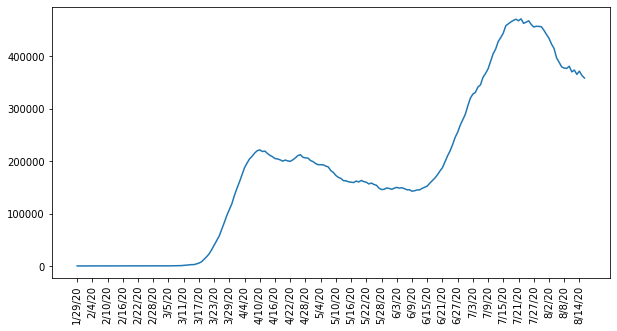

In [271]:
figure = plt.figure(figsize = (10,5))
plt.plot(increased_case)
plt.xticks(np.arange(0, len(increased_case.dropna()), 6)) 
plt.xticks(rotation=90)
plt.savefig("./img/Infected Case.jpg",  bbox_inches='tight')

In [272]:
# covid_lib.plot_all( total_cases, increased_case, yhat , "US" )

---

### Full Model Building

In [273]:

increased_case_21_train  = increased_case.iloc[:-21]
increased_case_14_train = increased_case.iloc[:-14]
increased_case_7_train  = increased_case.iloc[:-7]

increased_case_21_test = increased_case.iloc[-21:]
increased_case_14_test = increased_case.iloc[-14:]
increased_case_7_test = increased_case.iloc[-7:]

Test RMSE: 198.296


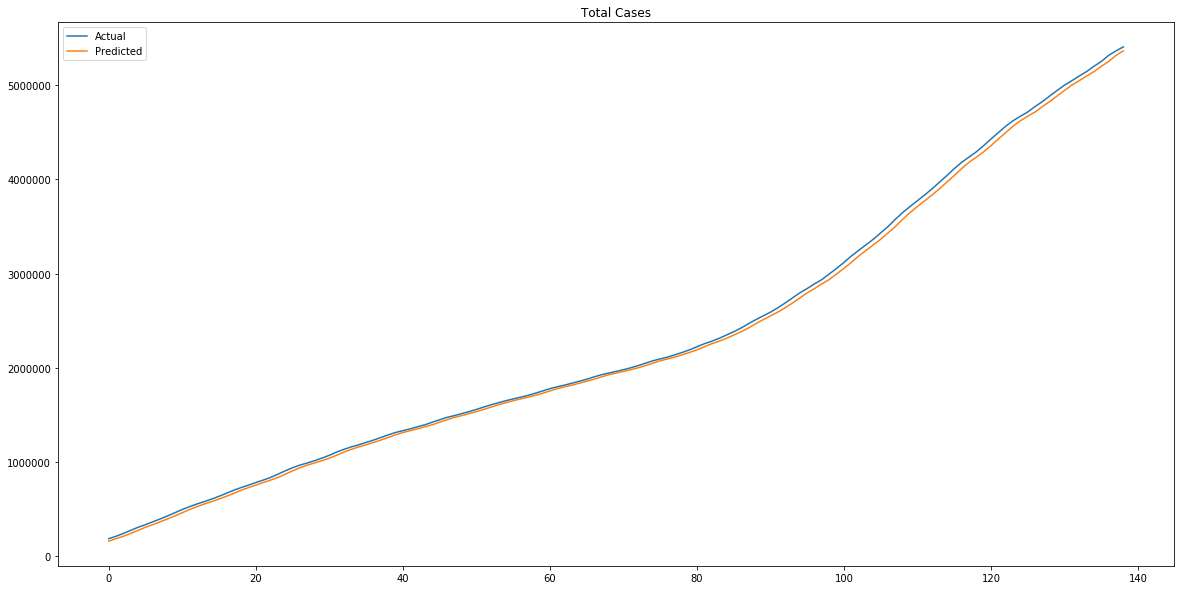

In [274]:
## This only predicts for one day
predictions_total, model_total = covid_lib.SARIMA_PREDICT(total_cases,"Total Cases", order_tuple = (0,1,0), seasonal_tuple=(1,1,1,24),fit_param = (True, True))
# predictions_total, model_total = covid_lib.SARIMA_PREDICT_edit(total_cases,"Total Cases", order_tuple = (0,1,0), fit_param = (True, True))

#### Predict future total Cases

26002.312481773257


Text(0.5, 1.0, 'This is what a SARIMA prediction looks like, RMSE : 26002.312481773257')

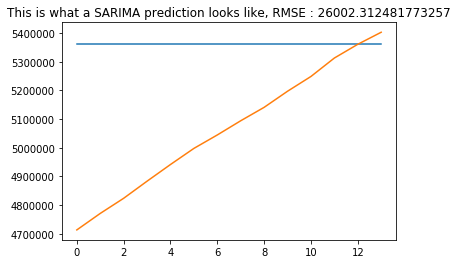

In [275]:
# today and tomorrow


temp = model_total.forecast(14)
rmse = sqrt(mean_squared_error(temp, total_cases[-14:])) / len(temp)
print(rmse)


plt.plot(temp)
plt.plot(total_cases[-14:])
plt.title("This is what a SARIMA prediction looks like, RMSE : " + str(rmse))




---

#### Count Increase Model Building

In [276]:
increased_case_14_train

,InfectedCount
1/29/20,4
1/30/20,4
1/31/20,5
2/1/20,6
2/2/20,3
...,...
7/29/20,456861
7/30/20,456199
7/31/20,449576
8/1/20,441622


/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 18.157


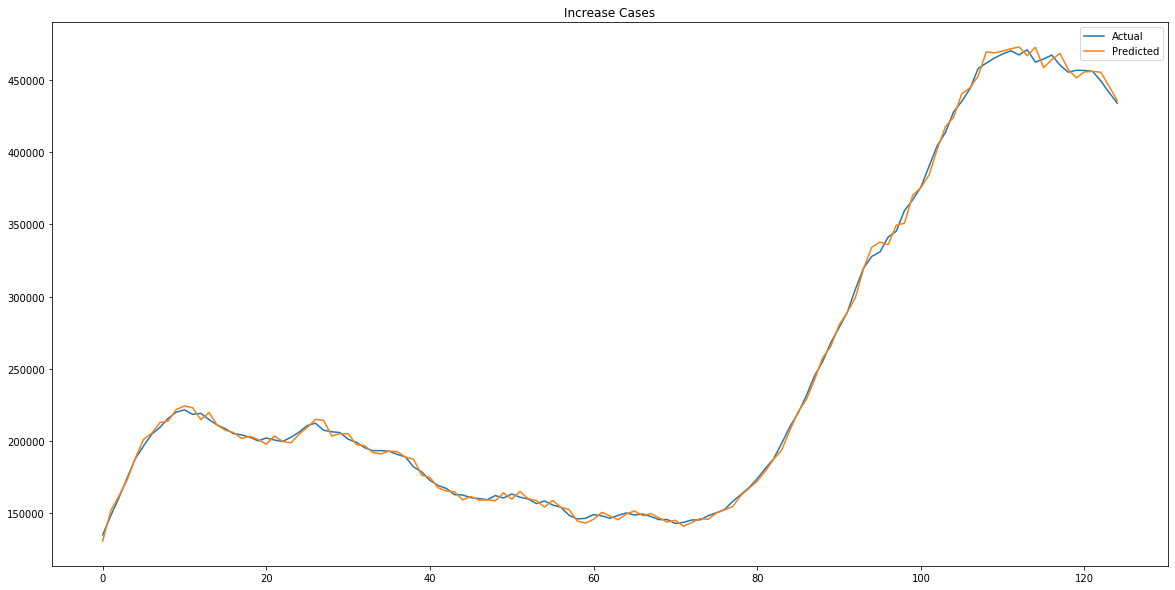

In [277]:
# Prediction for 14 days
increase_temp_14 = increased_case_14_train.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT(increase_temp_14, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

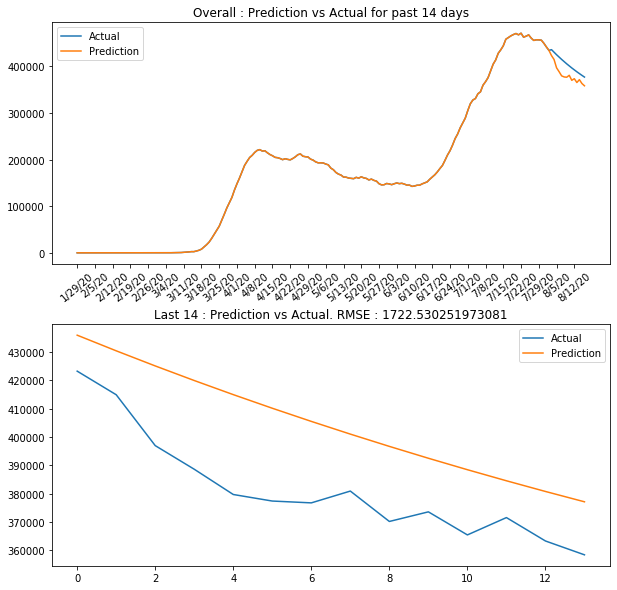

In [278]:
prediction_14 = model_increase.forecast(14)
prediction_14 = prediction_14.reshape(14, 1)
overall_prediction_14 = np.append(increase_temp_14, prediction_14)
# temp_l = increase_temp_14.append(temp)

rmse = sqrt(mean_squared_error( increased_case_14_test.values, prediction_14)) / len(prediction_14)
rmse

fig = plt.figure(figsize=(10,10)) 
fig.tight_layout()
plt.subplots_adjust(hspace = 0.25)

plt.subplot(2,1,1)
plt.plot(overall_prediction_14)
plt.plot(increased_case)
plt.xticks(np.arange(0, len(overall_prediction_14), 7))  
plt.xticks(rotation = 40)
plt.legend(["Actual", "Prediction"])
plt.title("Overall : Prediction vs Actual for past 14 days")

plt.subplot(2,1,2)
plt.plot(increased_case_14_test.values)
plt.plot(prediction_14)
plt.legend(["Actual", "Prediction"])
plt.title("Last 14 : Prediction vs Actual. RMSE : " + str(rmse))

plt.savefig("./img/SARIMA_NEXT_14_Prediction.png")

/home/mavericku/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Test RMSE: 18.217


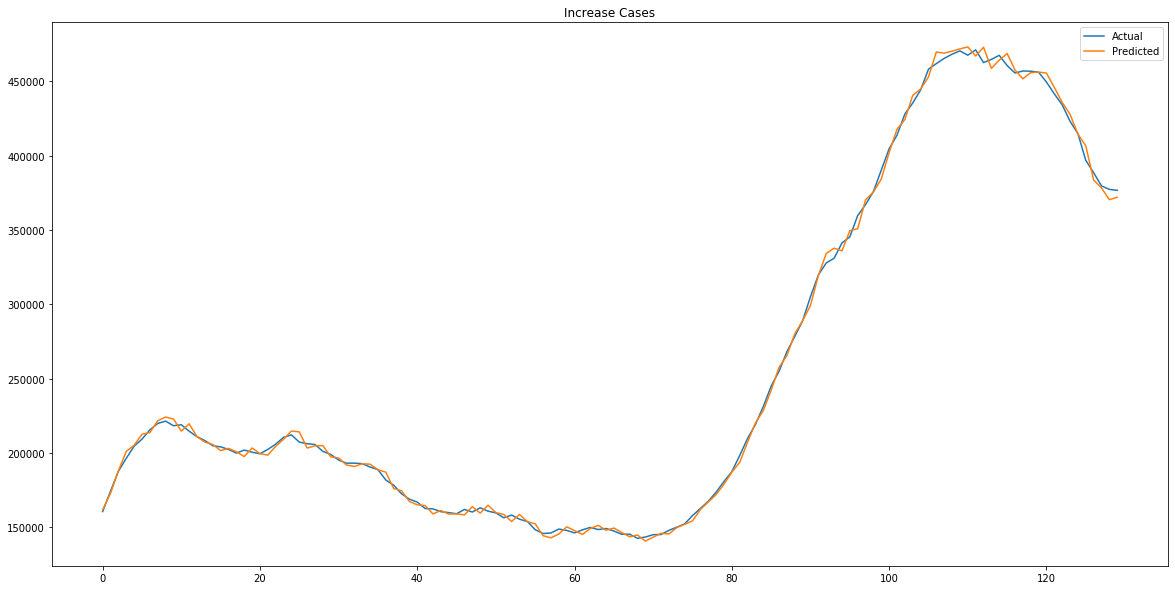

In [279]:
# Prediction for 7 days
increase_temp_7 = increased_case_7_train.values 
predictions_increase, model_increase = covid_lib.SARIMA_PREDICT(increase_temp_7, "Increase Cases",  is_increase_case = True, fit_param = (True,True) )

In [280]:
# plt.plot(increased_case)

In [281]:
# plt.plot(predictions_increase)

,InfectedCount,Predicted SARIMA
1/29/20,4,4
1/30/20,4,4
1/31/20,5,5
2/1/20,6,6
2/2/20,3,3
...,...,...
8/12/20,373521,362082
8/13/20,365376,357364
8/14/20,371497,352819
8/15/20,363236,348440


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

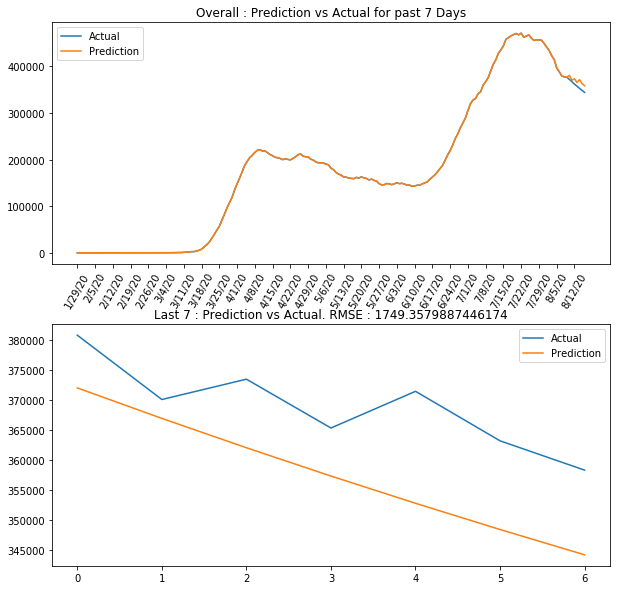

In [282]:
prediction_7 = model_increase.forecast(7)
prediction_7 = prediction_7.reshape(7, 1)
overall_prediction_7 = np.append(increase_temp_7, prediction_7)
# temp_l = increase_temp_14.append(temp)

rmse = sqrt(mean_squared_error( increased_case_7_test.values, prediction_7)) / len(prediction_7)
rmse

fig = plt.figure(figsize=(10,10))
fig.tight_layout()
plt.subplots_adjust(hspace = 0.25)
plt.subplot(2,1,1)
plt.plot(overall_prediction_7)
plt.plot(increased_case)
plt.xticks(np.arange(0, len(overall_prediction_7), 7))  
plt.xticks(rotation = 60)
plt.legend(["Actual", "Prediction"])
plt.title("Overall : Prediction vs Actual for past 7 Days")

plt.subplot(2,1,2)
plt.plot(increased_case_7_test.values)
plt.plot(prediction_7)
plt.legend(["Actual", "Prediction"])
plt.title("Last 7 : Prediction vs Actual. RMSE : " + str(rmse))
plt.savefig("./img/SARIMA_NEXT_7_Prediction.png")

In [318]:
### Bring prediction data to app
sarima_app_df = increased_case.copy()
sarima_app_df["Predicted SARIMA"] = overall_prediction_7
sarima_app_df.astype(int)

sarima_app_df_last7 = increased_case_7_test.copy()
sarima_app_df_last7["Predicted"] = prediction_7

sarima_app_df.to_csv("../Data/sarima_prediction_overall.csv")
sarima_app_df_last7.to_csv("../Data/sarima_prediction_last7.csv")


---

### Using Sentiment Values

In [283]:
def splitColumnSeries(sentiment_value_dataframe):
    
    SentimentValueTitle            = sentiment_value_dataframe.iloc[:,0]
    SentimentValueDescription      = sentiment_value_dataframe.iloc[:,1]
    SentimentValueTitleVader       = sentiment_value_dataframe.iloc[:,2]
    SentimentValueDescriptionVader = sentiment_value_dataframe.iloc[:,3]
    
    return (SentimentValueTitle, SentimentValueDescription ,SentimentValueTitleVader,SentimentValueDescriptionVader)

In [284]:
sentiment_value_dataframe = pd.read_csv("../Data/SentimentValues.csv", index_col = [0] )
#  sentiment_value = sentiment_value_dataframe.iloc[:,-4:]
# sentiment_value_dataframe

#### Split into train test data
sentiment_value_dataframe_train_14 = sentiment_value_dataframe.iloc[:-14]
sentiment_value_dataframe_test_14 = sentiment_value_dataframe.iloc[-14:]

sentiment_value_dataframe_train_7 = sentiment_value_dataframe.iloc[:-7]
sentiment_value_dataframe_test_7 = sentiment_value_dataframe.iloc[-7:]


sentiment_value_dataframe_train_21 = sentiment_value_dataframe.iloc[:-21]
sentiment_value_dataframe_test_21 = sentiment_value_dataframe.iloc[-21:]


SentimentValueTitle            = sentiment_value_dataframe.iloc[:,0]
SentimentValueDescription      = sentiment_value_dataframe.iloc[:,1]
SentimentValueTitleVader       = sentiment_value_dataframe.iloc[:,2]
SentimentValueDescriptionVader = sentiment_value_dataframe.iloc[:,3]

<IPython.core.display.Javascript object>

In [285]:
# #### 14 Days training data
# SentimentValueTitle, SentimentValueDescription ,SentimentValueTitleVader,SentimentValueDescriptionVader = splitColumnSeries(sentiment_value_dataframe_train_7)

In [286]:
predicted_length = int(len(increased_case_7_train.values) * 1 / 3)
sarima_prediction = increased_case_7_train.iloc[0:predicted_length,0].append(pd.Series(predictions_increase), ignore_index = True)

sarima_prediction_seq_ = sarima_prediction.values.reshape(len(sarima_prediction),1)

# len(sarima_prediction_seq_)

<IPython.core.display.Javascript object>

In [287]:
### JUST FOR REFERENCE
# increased_case_14_train = increased_case.iloc[:-14]
# increased_case_7_train  = increased_case.iloc[:-7]
# increased_case_14_test = increased_case.iloc[-14:]
# increased_case_7_test = increased_case.iloc[-7:]


def boosted_lstm(sentiment_value_dataframe , overall_prediction , target, testing_data, n_steps_in = 14, n_steps_out = 7):
    
    SentimentValueTitle, SentimentValueDescription ,SentimentValueTitleVader,SentimentValueDescriptionVader = splitColumnSeries(sentiment_value_dataframe)
    
    # define input sequence 
    
    predicted_length = int(len(overall_prediction.values) * 1 / 3)
    sarima_prediction = overall_prediction.iloc[0:predicted_length].append(pd.Series(predictions_increase), ignore_index = True)
    sarima_prediction_seq_ = sarima_prediction.values.reshape(len(sarima_prediction),1)
    out_seq = target.values.reshape(len(target.values), 1)
    
    SentimentValueDescription_seq     = SentimentValueDescription.values.reshape(len(SentimentValueDescription),1)
    SentimentValueTitleVader_seq      = SentimentValueTitleVader.values.reshape(len(SentimentValueTitleVader),1)
    SentimentValueDescriptionVader_seq= SentimentValueDescriptionVader.values.reshape(len(SentimentValueDescriptionVader),1)
    SentimentValueTitle_seq           = SentimentValueTitle.values.reshape(len(SentimentValueTitle),1)

    
    print("sarima_prediction_seq_" + str(len(sarima_prediction_seq_)))
# #     sarima_output_all = prediction.reshape(len(prediction),1)    
# #     print(len(sarima_output_all))
#     print(len(SentimentValueDescription_seq)  )
#     print(len(SentimentValueTitleVader_seq      )  )
#     print(len(SentimentValueDescriptionVader_seq)  )
#     print(len(SentimentValueTitle_seq           )  )
#     print(len(out_seq))
    
    
    # horizontally stack columns
    # dataset = hstack((in_seq1, in_seq2, out_seq))
    dataset = hstack((
                    sarima_prediction_seq_,
                    SentimentValueDescription_seq , 
                      SentimentValueTitleVader_seq, 
                      SentimentValueDescriptionVader_seq,
                      SentimentValueTitle_seq,
                      out_seq))

    ################### Building the testing dataset ###################
    
    ## Testing_Date : SENTIMENT_DATAFRAME, SARIMA_PREDICTION, TARGET_VALUE
    SentimentValueTitle_test, SentimentValueDescription_test ,SentimentValueTitleVader_test,SentimentValueDescriptionVader_test = splitColumnSeries(testing_data[0])
    
    SentimentValueDescription_seq_test     = SentimentValueDescription_test.values.reshape(len(SentimentValueDescription_test),1)
    SentimentValueTitleVader_seq_test      = SentimentValueTitleVader_test.values.reshape(len(SentimentValueTitleVader_test),1)
    SentimentValueDescriptionVader_seq_test= SentimentValueDescriptionVader_test.values.reshape(len(SentimentValueDescriptionVader_test),1)
    SentimentValueTitle_seq_test           = SentimentValueTitle_test.values.reshape(len(SentimentValueTitle_test),1)
    
#     print(len(testing_data[1]))
#     print(len(SentimentValueDescription_seq_test)  )
#     print(len(SentimentValueTitleVader_seq_test      )  )
#     print(len(SentimentValueDescriptionVader_seq_test)  )
#     print(len(SentimentValueTitle_seq_test           )  )
    
    test_input = hstack((
                    testing_data[1],
    SentimentValueDescription_seq_test     ,
    SentimentValueTitleVader_seq_test      ,
    SentimentValueDescriptionVader_seq_test,
    SentimentValueTitle_seq_test           ))
  


    ################### Multivariate, Multi Timestep LSTM ###################

    n_steps_in, n_steps_out = 14, 7
    X, y = covid_lib.split_sequences_three(dataset, n_steps_in, n_steps_out)
    n_features = X.shape[2] 
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
#     model.add(LSTM(100, activation='relu', return_sequences=True))
#     model.add(LSTM(100, activation='relu', return_sequences=True))

#     model.add(LSTM(100, activation='relu', return_sequences=True))

    model.add(LSTM(100, activation='relu'))

    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=200, verbose=0)
    
    
    ################### Testing Results ###################

#     x_input = test_input[-n_steps_in:]
    x_input = test_input    
    
    ### reshape : sample count, time step, features
    x_input = x_input.reshape((1, n_steps_in, n_features))
    # print(x_input)
    yhat = model.predict(x_input, verbose=1)
    print(yhat)
    
    
    return model,yhat

testing_data = (sentiment_value_dataframe_test_14, prediction_14 ,increased_case_14_test)
    
lstm_model,yhat = boosted_lstm(sentiment_value_dataframe_train_7 , 
                          sarima_prediction  ,
                          increased_case_7_train, 
                          testing_data)

<IPython.core.display.Javascript object>

sarima_prediction_seq_194
1/1 [==============================] - 0s 2ms/step
[[379736.34 340652.66 418105.78 372913.2  337630.06 388413.75 324255.72]]


In [288]:

aggregate_df = increased_case.copy()
temp_sarima = sarima_prediction.copy()
temp_sarima
N = 4
for i in range(len(sarima_prediction) , len(aggregate_df)):
    temp_sarima = temp_sarima.set_value(i, np.nan)
sarima_df = pd.DataFrame({"SARIMA":temp_sarima, "Index": aggregate_df.index}).set_index(["Index"])
aggregate_df = pd.concat([aggregate_df, sarima_df], axis = 1)
# plt.plot(aggregate_df)

<IPython.core.display.Javascript object>

/home/mavericku/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [300]:
sarima_length = len(full_sarima_prediction)
full_sarima_prediction = temp_sarima.copy()
for i in range(sarima_length-7, sarima_length):
    full_sarima_prediction.iloc[i] = prediction_7[i-sarima_length]

In [322]:
sentiment_value_dataframe_test_21.to_csv("../Data/App/sentiment_last_21.csv") 

<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 3ms/step
[[425298.44 381940.06 465653.03 419276.94 377501.06 436102.53 361516.9 ]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

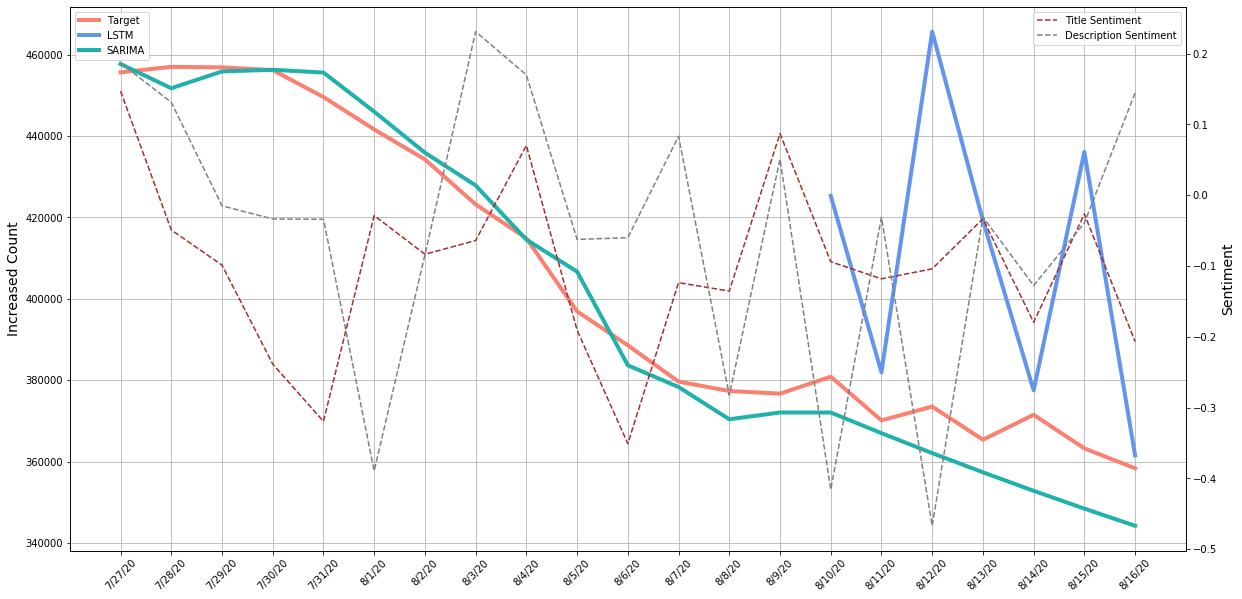

In [326]:
sentiment_value_dataframe_test_21.index = increased_case_21_test.index
# sentiment_value_dataframe_test_21

def testing_boosted_lstm(sentiment_value_dataframe_test_21, sarima_prediction ,
                         target,full_sarima_prediction, lstm_model,
                    n_steps_in = 14, n_steps_out =  7 , n_features = 5):
    
    
    
    ## Testing_Date : SENTIMENT_DATAFRAME, SARIMA_PREDICTION, TARGET_VALUE
    SentimentValueTitle_test, SentimentValueDescription_test ,SentimentValueTitleVader_test,SentimentValueDescriptionVader_test = splitColumnSeries(sentiment_value_dataframe_test_21[:-7])
    
    SentimentValueDescription_seq_test     = SentimentValueDescription_test.values.reshape(len(SentimentValueDescription_test),1)
    SentimentValueTitleVader_seq_test      = SentimentValueTitleVader_test.values.reshape(len(SentimentValueTitleVader_test),1)
    SentimentValueDescriptionVader_seq_test= SentimentValueDescriptionVader_test.values.reshape(len(SentimentValueDescriptionVader_test),1)
    SentimentValueTitle_seq_test           = SentimentValueTitle_test.values.reshape(len(SentimentValueTitle_test),1)
    
    sarima_prediction = np.array(sarima_prediction).reshape(len(sarima_prediction),1)
    
#     print(len(sarima_prediction))
#     print(len(SentimentValueDescription_seq_test)  )
#     print(len(SentimentValueTitleVader_seq_test      )  )
#     print(len(SentimentValueDescriptionVader_seq_test)  )
#     print(len(SentimentValueTitle_seq_test           )  )
    
    test_input = hstack((
                    sarima_prediction,
    SentimentValueDescription_seq_test     ,
    SentimentValueTitleVader_seq_test      ,
    SentimentValueDescriptionVader_seq_test,
    SentimentValueTitle_seq_test           ))
    
    ################### Predict ###################

    
    x_input = test_input    
    
    ### reshape : sample count, time step, features
    x_input = x_input.reshape((1, n_steps_in, n_features))
    # print(x_input)
    yhat = lstm_model.predict(x_input, verbose=1)
    print(yhat)
#     plt.plot(target)
#     plt.plot(yhat[0].tolist())
#     plt.legend(["Actual","Predicted"])
#     plt.xticks(rotation = 90)

#     yhat_df = pd.DataFrame(np.vstack(yhat[0]), index = temp.index)



    yhat_df = pd.DataFrame(np.vstack(yhat[0]), index = increased_case_21_test[-7:].index)
    yhat_df.to_csv("../Data/App/boosted_predict.csv")
    
    fig, ax = plt.subplots()
    fig.set_size_inches((20, 10))
    ax.plot(target.index,target, lw = 4, color = "salmon")
    ax.plot(target.index[-7:], yhat_df, lw = 4, color = 'cornflowerblue')
    ax.plot(target.index, full_sarima_prediction[-21:], lw= 4,color = "lightseagreen" )
    ax.tick_params(axis = "x", rotation = 45)
    ax.set_ylabel("Increased Count" , size = 14)
    ax.legend(["Target", "LSTM", "SARIMA"] ,loc = 2)
#     ax.xticks(rotation = 45)
    
    ax2 = ax.twinx()
    linestyles = '--'
    
    
    ax2.plot(sentiment_value_dataframe_test_21["SentimentValueTitleVader"], color = "brown", linestyle = linestyles)
    ax2.plot(sentiment_value_dataframe_test_21["SentimentValueDescriptionVader"], color = "grey", linestyle = linestyles)
    ax2.set_ylabel("Sentiment", size = 14)
    ax2.legend(["Title Sentiment", "Description Sentiment"],loc = 1)
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)
    
    plt.savefig("./img/FinalModelPrediction.png")
#     fig = plt.figure(figsize=(20,15))
#     plt.subplots_adjust(hspace=0.25)
#     plt.subplot(2,1,1)
    
#     plt.plot(target, linewidth=3)
# #     plt.plot(sarima_prediction[-21:])  
#     plt.plot(yhat_df, lw = 3)
#     plt.plot(full_sarima_prediction[-21:].values, lw = 3)
#     plt.xticks(rotation = 45)
#     plt.legend(["Target", "SARIMA", "LSTM"])
#     plt.ylabel("Infected Count", size = 16)
#     plt.xlabel("Changes According to time", size = 16)
#     plt.grid("on")
    
#     plt.subplot(2,1,2)
#     plt.plot(sentiment_value_dataframe_test_21["SentimentValueTitleVader"])
#     plt.plot(sentiment_value_dataframe_test_21["SentimentValueDescriptionVader"])
# #     plt.plot(sentiment_value_dataframe_test_21.mean(axis=1).values)
#     plt.ylabel("Sentiment Value", size = 16)
#     plt.xlabel("Changes according to date" , size = 16)
#     plt.xticks(rotation = 45)
#     plt.grid("on")
#     sns.despine()
#     plt.savefig("FinalModelPrediction.png")
    
     ################### Validate ###################

    
    
    return lstm_model,yhat
  
    
# testing_data = testing_boosted_lstm(sentiment_value_dataframe_test_21, prediction_14 ,increased_case_21_test, lstm_model)


model, yhat = testing_boosted_lstm(sentiment_value_dataframe_test_21, sarima_prediction[-21:-7] ,increased_case_21_test, full_sarima_prediction,lstm_model)


In [291]:
# def test_lstm( sentiment_value_dataframe , prediction , target, lstm_model):
  
#     SentimentValueTitle, SentimentValueDescription ,SentimentValueTitleVader,SentimentValueDescriptionVader = splitColumnSeries(sentiment_value_dataframe)
    
#     # define input sequence 
# #     prediction
# #     predicted_length = int(len(prediction) * 1 / 3)
# #     sarima_prediction = prediction[0:predicted_length].append(pd.Series(predictions_increase), ignore_index = True)
# #     sarima_prediction_seq_ = sarima_prediction.values.reshape(len(sarima_prediction),1)
#     out_seq = target.values.reshape(len(target.values), 1)
    
#     SentimentValueDescription_seq     = SentimentValueDescription.values.reshape(len(SentimentValueDescription),1)
#     SentimentValueTitleVader_seq      = SentimentValueTitleVader.values.reshape(len(SentimentValueTitleVader),1)
#     SentimentValueDescriptionVader_seq= SentimentValueDescriptionVader.values.reshape(len(SentimentValueDescriptionVader),1)
#     SentimentValueTitle_seq           = SentimentValueTitle.values.reshape(len(SentimentValueTitle),1)

    
    

#     test_input = hstack((
#                     prediction,
#                     SentimentValueDescription_seq , 
#                       SentimentValueTitleVader_seq, 
#                       SentimentValueDescriptionVader_seq,
#                       SentimentValueTitle_seq))


    
# # test_lstm(sentiment_value_dataframe_test_7 , prediction ,increased_case_7_test , lstm_model )


---

## Correlation 


In [293]:
temp_sentiment = sentiment_value_dataframe.copy()
temp_sentiment["IncreaseCount"] = increased_case.values
temp_sentiment

,SentimentValueTitle,SentimentValueDescription,SentimentValueTitleVader,SentimentValueDescriptionVader,IncreaseCount
PublishedTime,,,,,
2020-01-29,0.255208,0.153056,-0.438800,-0.069083,4
2020-01-30,0.022386,0.040869,0.058820,-0.249390,4
2020-01-31,-0.093182,0.007828,-0.218489,-0.199178,5
2020-02-01,0.067340,0.135278,-0.117200,0.247789,6
2020-02-02,0.000000,0.129167,-0.363450,-0.707050,3
...,...,...,...,...,...
2020-08-12,0.024858,0.063760,-0.104125,-0.467087,373521
2020-08-13,-0.137500,-0.080238,-0.033287,-0.030875,365376
2020-08-14,-0.042992,0.190265,-0.179600,-0.127713,371497


<IPython.core.display.Javascript object>

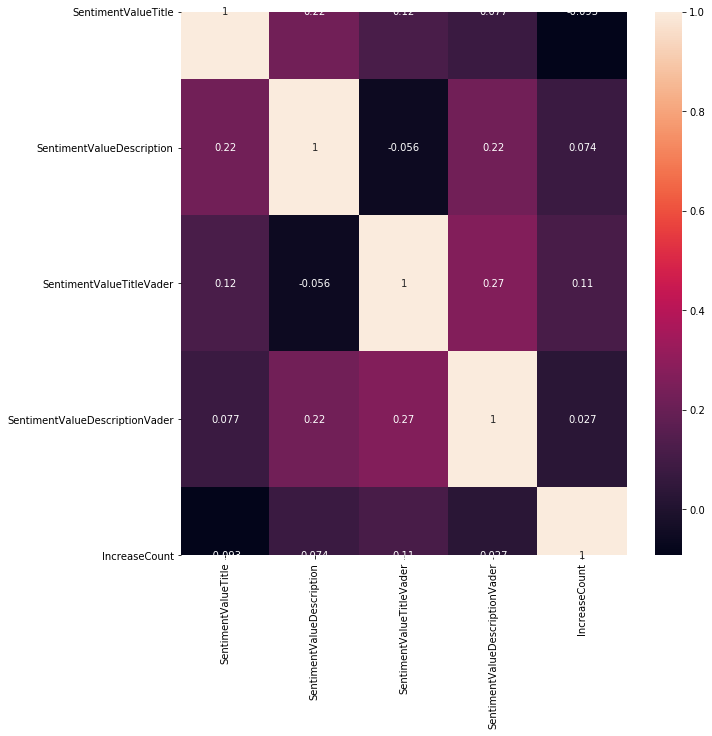

In [294]:
corrMatrix = temp_sentiment.corr()

plt.figure(figsize=(10,10))
sns.heatmap( corrMatrix, annot=True)
# plt.figure(figsize = (20,20))
plt.savefig("CorrelationMap.png")